# Setup

In [58]:
import json
import requests
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime,timezone,date,timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_score,davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN,AgglomerativeClustering
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.colors
from statsmodels.graphics import tsaplots
from sklearn.mixture import GaussianMixture
import pytz
import random
from sklearn.metrics import normalized_mutual_info_score
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

# Read data

In [6]:
def read_data(path_to_csv,date_columns = [],index_columns=[]):
    df = pd.read_csv(path_to_csv,parse_dates=date_columns,index_col=index_columns)
    return df

# Prepare for clustering

In [10]:
def prepare_for_clustering(df,devices=devices_to_cluster):
    """
    Function for pereparing pre-processed data of a specific device before clustering.
   
    :params:
    -------
        df : pre-processed data frame
        devices: a list of devices codes to include in clustering if passed an empty list; all devices will be included.
    
    :returns:
    --------
        df_pivot: pivoted dataframe having the hours as columns , energy consumption as values , device code and date as Multindex.

    """
    # Filter the dataframe for the chosen devices only
    if devices is not None:
        df = df[df.device_code.isin(devices)]
    
    # Create the pivoted dataframe
    df_filtered = df[["energy","device_code"]]
    df_filtered['hour'] = df_filtered.index.hour
    df_filtered= df_filtered.set_index(["device_code",df_filtered.index.date])
    df_pivot = df_filtered.pivot(columns='hour')
    df_pivot = df_pivot.dropna() # drop rows with missing hours
    df_pivot.columns = df_pivot.columns.droplevel()
    
    # Plot hourly consumption for all days for all devices
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    df_pivot.T.plot(ax=ax, legend=False, color='blue', alpha=0.05)
    #ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    #ax.grid(which='minor', alpha=0.6)
    #ax.grid(which='major', alpha=1)
    ax.set_xticks(np.arange(1,25))
    plt.title("Consumption profiles for all devices",fontsize=14)
    plt.ylabel("Energy in KWh",fontsize=12)
    plt.xlabel("Hours",fontsize=12)
    plt.show()
    
    
    return df_pivot
    

# Clustering

In [90]:
def get_clusters(model,df_pivot,n_clusters,normalize=True):
    """
    This function fit the passed clustering algorithm to the data and returns the data with the corresponding labels.
    
    :params:
    --------
        model: a class representing the clustering algorithm ,it is either KMeans or Spectralclustering classes
        df_pivot: a dataframe with hours as columns and dates as index
        n_clusters: number of clusters
        normalize: whether to normalize the data before clustering or not default to True
        
    :returns:
    ---------
        df_pivot: the same dataframe passed as input plus the cluster labels added as new index level
    """

    min_clusters = 2
    max_clusters = 15
    n_cluster_list = np.arange(min_clusters,max_clusters).astype(int)

    X = df_pivot.values.copy()
    
    # Normalize the data each day separately
    if normalize:
        sc = MinMaxScaler()
        X = sc.fit_transform(X.T)
        X = X.T
        
    
    # Create a graph for the elbow method
    cluster_model = model()
    visualizer = KElbowVisualizer(cluster_model, k=(min_clusters,max_clusters),timings=False,random_state=0)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()     

    # Create a graph for the silhoutte score
    cluster_model = model()
    visualizer2 = KElbowVisualizer(cluster_model, k=(min_clusters,max_clusters),metric='silhouette',timings=False,locate_elbow=True,random_state=0)
    visualizer2.fit(X)        # Fit the data to the visualizer
    visualizer2.show()    
    
    # calculate the davies score  and mutual information score for each number of clusters
    davies_scores=[]
    mutual_info_scores=[]
    for n_cluster in n_cluster_list:
        cluster_model = model(n_clusters=n_cluster,random_state=0)
        cluster_found = cluster_model.fit_predict(X)
        davies_scores.append(davies_bouldin_score(X, cluster_model.labels_))
        mutual_info_scores.append(normalized_mutual_info_score(df_pivot.index.get_level_values(0).values, cluster_model.labels_))
    
    # plot davies scores
    plt.plot(n_cluster_list,davies_scores,marker='^')
    plt.title("Davies score")
    plt.show()
    
    #plot mutual info scores
    plt.plot(n_cluster_list,mutual_info_scores,marker='o')
    plt.title("Mutual Info score")
    plt.ylabel("Score")
    plt.xlabel("K")
    plt.show()
    
    
    # Cluster the data with the given number of clusters
    cluster_model = model(n_clusters=n_clusters,random_state=0)
    cluster_found = cluster_model.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    
    # Append the clusters labels as index to the dataframe
    df_pivot = df_pivot.set_index(cluster_found_sr, append=True )
    

    # Plot the data colored by their corresponding clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    color_list = ['blue','red','green',"orange","black","purple","brown","cyan"]
    cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, color_list):
        print(cluster,color)
        df_pivot.xs(cluster, level=2).T.plot(ax=ax, alpha=0.1, legend=False,color=color) # plot all days colored by cluster
        df_pivot.xs(cluster, level=2).median().plot(
            ax=ax, color=color, alpha=0.9, ls='--',legend=True,label=f"Cluster{cluster}") #plot the median profile for each cluster
    
    plt.ylabel("Energy Consumption",fontsize=12)
    plt.xlabel("Hours",fontsize=12)
    plt.title(f"Clusters using {cluster_model.__class__.__name__}",fontsize=15)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='minor', alpha=0.6)
    ax.grid(which='major', alpha=1)
    plt.show()
    
  
    # TSNE plot to visualize the clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=df_pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.5)
    plt.show()
    return df_pivot


def dbscan_cluster(df_pivot,eps=None,min_samples=3,normalize=True,eps_list=[]):
    """
    This function perform clustering on the input data using dbscan.
    
    :params:
    -------
        df_pivot: a dataframe with hours as columns and dates as index
        eps : the max space between points in a cluster
        min_samples: min number of samples to be considered as a clusters
        normalize: whether to normalize the data before clustering or not default to True
    :returns:
    ---------
        df_pivot: the same dataframe passed as input plus the cluster labels added as new index level

    """
    X = df_pivot.values.copy()
    
    # Normalize the data each day separately
    if normalize:
        sc = MinMaxScaler()
        X = sc.fit_transform(X.T)
        X = X.T

        
    # get the elbow graph for nearest neigbor distances to locate the elbow 
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)
    dist,_ =neigh.kneighbors(X)
    min_dist = np.min(dist[:,1:],axis=1)
    plt.plot(np.arange(len(min_dist)),np.sort(min_dist))
    plt.title("Min distance of each point to its neighbours")
    plt.xlabel("Points")
    plt.ylabel("Distances")
    plt.show()
    
    # if the value of eps is not passed ,then find the eps the results in highest silhouette score.
    if eps is None:
        silhouette_scores=[]
        for ep in eps_list:
            mymodel = DBSCAN(eps=ep, min_samples=min_samples)
            cluster_found = mymodel.fit_predict(X)
            try:
                silhouette_scores.append(silhouette_score(X, mymodel.labels_))
            except ValueError:
                # exception raised when there is only one cluster
                silhouette_scores.append(0)
        selected_eps = eps_list[silhouette_scores.index(np.max(silhouette_scores))] 
        eps = selected_eps
        
        #plot the silhouette score for each eps
        plt.plot(eps_list,silhouette_scores,marker='^')
        plt.title("Silhouette score")
        plt.ylabel("Silhouette score")
        plt.xlabel("K")
        plt.show()
        print(eps)
    
    # Start clustering
    mymodel = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_found = mymodel.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df_pivot = df_pivot.set_index(cluster_found_sr, append=True )
    
    #plot the clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    color_list = ['blue','red','green',"orange","black","purple","brown","cyan"]
    cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, color_list):
        print(cluster,color)
        df_pivot.xs(cluster, level=2).T.plot(ax=ax, legend=False, alpha=0.1, color=color,)
        df_pivot.xs(cluster, level=2).median().plot(ax=ax, color=color, alpha=0.9, ls='--',legend=True,label= f'Cluster {cluster}')
    plt.ylabel("Energy Consumption",fontsize=12)
    plt.xlabel("Hours",fontsize=12)
    plt.title("Clusters using DBSCAN",fontsize=15)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1)
    plt.show()

    
    # TSNE plot to visualize the clusters
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],c=df_pivot.index.get_level_values('cluster'),cmap=cmap, alpha=0.6)
    
    
    return df_pivot

def hdbscan_cluster(df_pivot,min_cluster_size,min_samples,normalize=True):
    
    X = df_pivot.values.copy()
    
    # Normalize the data each day separately
    if normalize:
        sc = MinMaxScaler()
        X = sc.fit_transform(X.T)
        X = X.T
        
    # Start clustering
    hdb = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size)
    cluster_found = hdb.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df_pivot  = df_pivot.set_index(cluster_found_sr, append=True )
    
    # plot condensed tree
    hdb.condensed_tree_.plot(select_clusters=True)

    
    # plot the clusters
    fig, ax= plt.subplots(1,1, figsize=(18,10))
    color_list = ['blue','red','green',"orange","black","purple","brown","cyan","olive","pink","lime"]
    cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, color_list):
        print(cluster,color)
        df_pivot.xs(cluster, level=2).T.plot(
            ax=ax, legend=False, alpha=0.1, color=color,
            )
        df_pivot.xs(cluster, level=2).median().plot(
            ax=ax, color=color, alpha=0.9, ls='--',legend=True,label= f'Cluster {cluster}')
    plt.show()

    print(" The silhouette score is ",silhouette_score(X, hdb.labels_))

    
    # TSNE plot to visualize the clusters
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=df_pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6)
    plt.show()
    
    return df_pivot

# Results visualisation


In [47]:
def visualize_results(df,clusters_results):
    """
    This function shows the devices in each cluster
    
    :params:
        df: a dataframe with timestamp as index
        clusters_results: dataframe with dates and cluster labels as index and hours as columns
    """
    # Aggregate the results of clustering for each device
    clusters_results = clusters_results.reset_index()
    grouped_clusters = clusters_results.groupby(["device_code","cluster"]).agg({'cluster': [('count', 'count')]})
    grouped_clusters.columns = grouped_clusters.columns.droplevel()
    

    # Get the cluster label for each device according to the maximum number of days appearing in clusters
    max_per_device = grouped_clusters.unstack().idxmax(axis=1)
    max_per_device = max_per_device.reset_index()
    max_per_device["cluster"] = max_per_device[0].apply(lambda x : x[1])
    max_per_device.drop(0,axis=1,inplace=True)

    # plot the profiles of devices in each cluster
    for cluster in np.unique(max_per_device["cluster"]):
        fig, ax= plt.subplots(1,1, figsize=(10,8))
        similar = max_per_device.loc[max_per_device["cluster"]==cluster]["device_code"]
        df2 = df[df.device_code.isin(similar)]
        df_filtered = df2[["energy","device_code"]]
        df_filtered['hour'] = df_filtered.index.hour
        df_filtered= df_filtered.set_index(["device_code",df_filtered.index.date])
        df_pivot = df_filtered.pivot(columns='hour')
        df_pivot = df_pivot.dropna()
        df_pivot.columns = df_pivot.columns.droplevel()
        sns.lineplot(ax=ax,data=df_pivot.T,ci=95)
        ax.set_xticks(np.arange(0,24))
        plt.title(f"Cluster {cluster}",fontsize=14)
        plt.ylabel("Energy Consumption",fontsize=12)
        plt.xlabel("Hours",fontsize=12)
        plt.show()       
    



In [54]:
def analyse_cluster(clusters):
    """
    This function shows analysis plots for each cluster 
    
    :params:
    clusters : dataframe with dates and cluster labels as index and hours as columns
    """

    number_of_clusters = len(np.unique(clusters.index.get_level_values(1)))
    
    clusters = clusters.reset_index()
    clusters.rename(columns={"level_1":"date"},inplace=True)
    clusters["day_name"] = pd.to_datetime(clusters["date"]).dt.day_name()
    clusters["week_of_month"] =  pd.to_datetime(clusters['date']).apply(lambda d: f"week {(d.day-1) // 7 + 1}")
    clusters["month"] = pd.to_datetime(clusters["date"]).dt.month
    clusters["month"] = clusters["month"].apply(lambda x: calendar.month_abbr[x])


    
    # Plot the number of days appearance per cluster
    clusters_days = clusters.groupby(["cluster","day_name"]).agg(count_day=("day_name","count"))
    clusters_days = clusters_days.reset_index()
    fig, ax= plt.subplots(1,1, figsize=(12,4))
    sns.barplot(ax=ax,x="cluster",y="count_day", hue="day_name",data=clusters_days,palette='tab10',hue_order=["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])
    plt.title("Number of day appearance per cluster", fontsize=17)
    plt.ylabel("Number of days", fontsize=15)
    plt.xlabel("Clusters",fontsize=15)
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
    
    # Plot the number of day appearance per week in each cluster
    clusters_weeks = clusters.groupby(["cluster","week_of_month"]).agg(count_week=("week_of_month","count"))
    clusters_weeks = clusters_weeks.reset_index()
    fig, ax= plt.subplots(1,1, figsize=(12,4))
    sns.barplot(ax=ax,x="cluster",y="count_week", hue="week_of_month",data=clusters_weeks,palette='tab10')
    plt.title("Number of day appearance per week in each cluster", fontsize=17)
    plt.ylabel("Number of days", fontsize=15)
    plt.xlabel("Clusters",fontsize=15)
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
    print(" \n"*3)
    fig, ax= plt.subplots(1,len(np.unique(clusters["cluster"])) , figsize=(20,18))
    

    cluster_week_month = clusters.groupby(["cluster","month","week_of_month"]).agg(value = ("week_of_month","count"))
    cluster_week_month = cluster_week_month.reset_index()

    for cluster in np.unique(clusters["cluster"]):

        df_cluster = cluster_week_month.loc[clusters["cluster"]==cluster]
        
        # Pie chart for the month percentage in each cluster
        ag = df_cluster.groupby(["month"]).agg({"value":"sum"})
        ag=ag.reset_index()
        colors=('r', 'b', 'y', 'm', 'c', 'burlywood', 'w')
        ax[cluster].pie(ag["value"],labels=ag["month"],autopct='%1.f%%',pctdistance=0.85,textprops={'fontsize': 20},colors=colors)
        centre_circle = plt.Circle((0, 0), 0.60, fc='white')
        ax[cluster].add_artist(centre_circle)
        ax[cluster].set_title(f"Month percentage in cluster {cluster}",fontsize=20)
        plt.tight_layout()

    
        # Plot the number of day appearance per week per month in each cluster
        fig = px.sunburst(df_cluster, path=['month',"week_of_month"], values='value',
                         title=f"Cluster {cluster}")
        fig.update_layout(margin = dict(t=100, l=20, r=20, b=20))
        fig.update_traces(textinfo="label+value")
        fig.show()
        
        
        
    



# Pipeline

In [ ]:
df = read_data("modon1_processed_1_v2.csv",date_columns = ["transformed_timestamp"],index_columns=["transformed_timestamp"])

In [ ]:
devices_to_cluster = [8432,8443,9122,9123,9143,9144,9145,8847,14404,14405,14406,14408,14410,14411,14452,14453,14454,14458,14459,14460,14462,14463,14464]
df_pivot = prepare_for_clustering(df)

In [ ]:
spectral_clusters = get_clusters(SpectralClustering,df_pivot,4,normalize=True)

In [ ]:
kmeans_clusters = get_clusters(KMeans,df_pivot,3)

In [ ]:
dbscan_clusters = dbscan_cluster(df_pivot,eps=1,min_samples=48,normalize=True)

-1 blue
0 red
1 green
2 orange
3 black
4 purple


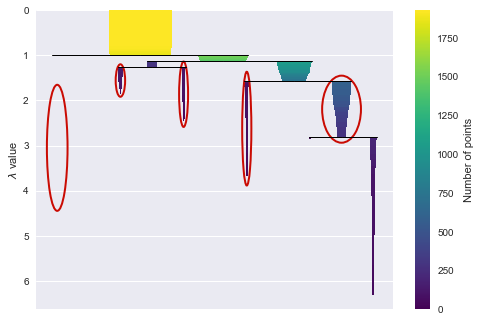

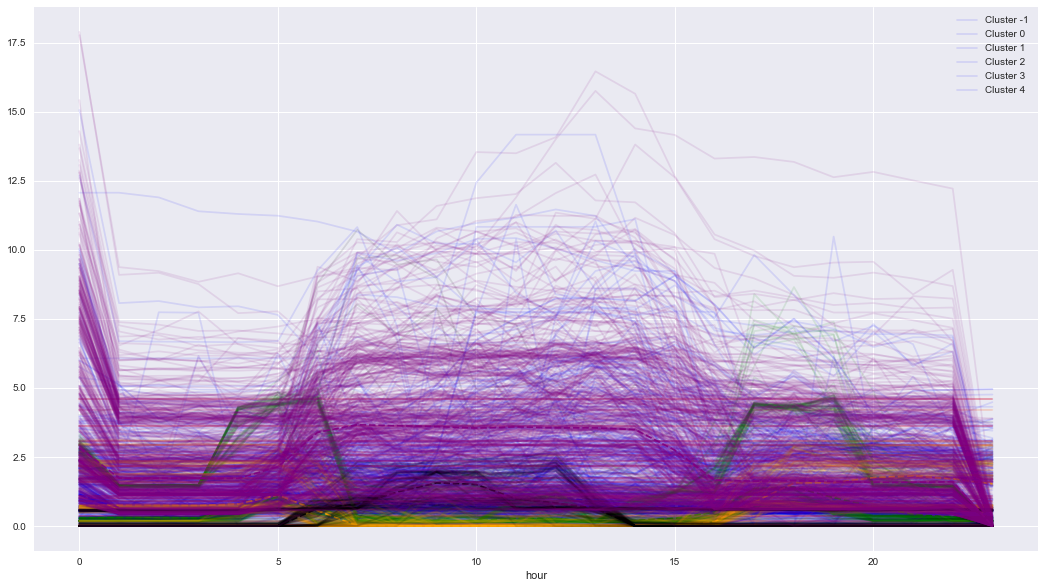

 The silhouette score is  0.26601605656901844


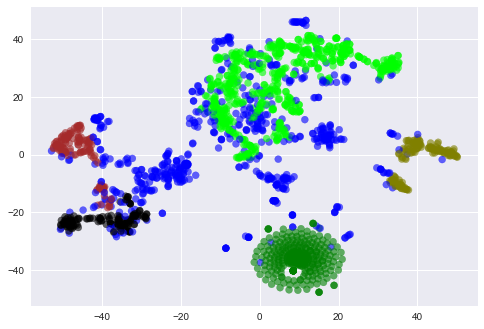

In [89]:
Hbscan_clusters = hdbscan_cluster(df_pivot,48,1,normalize=True)

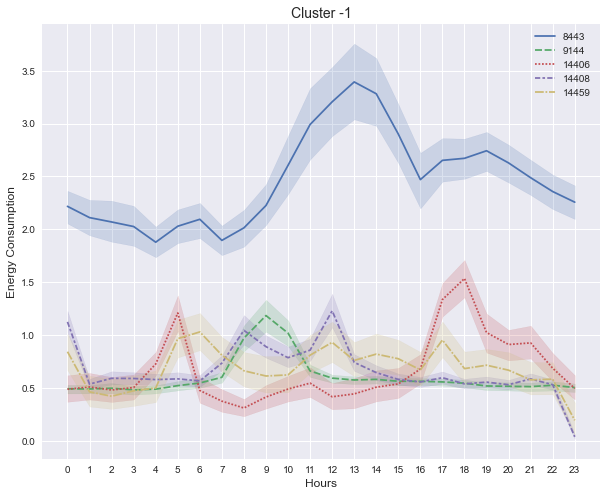

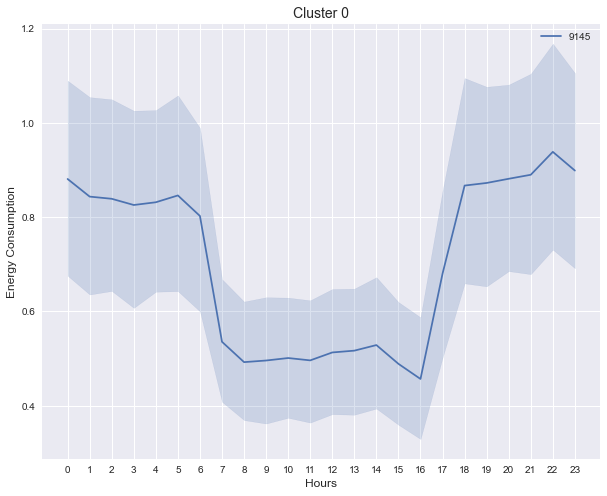

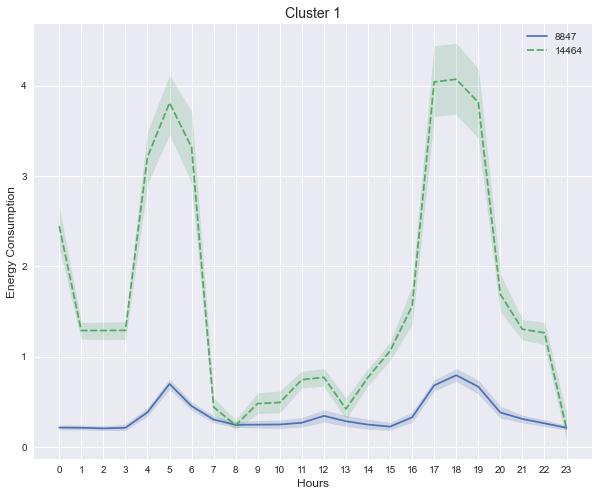

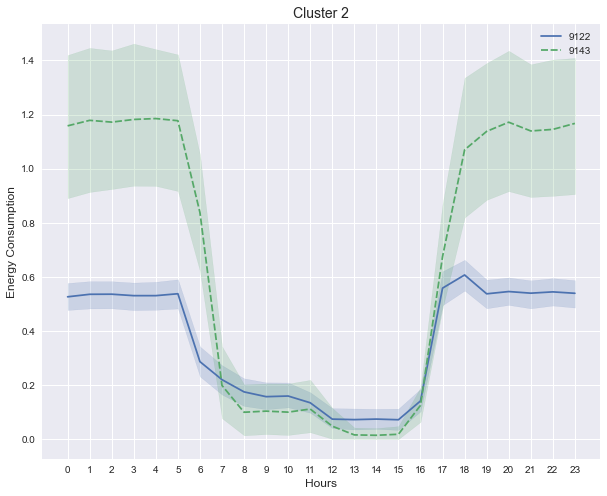

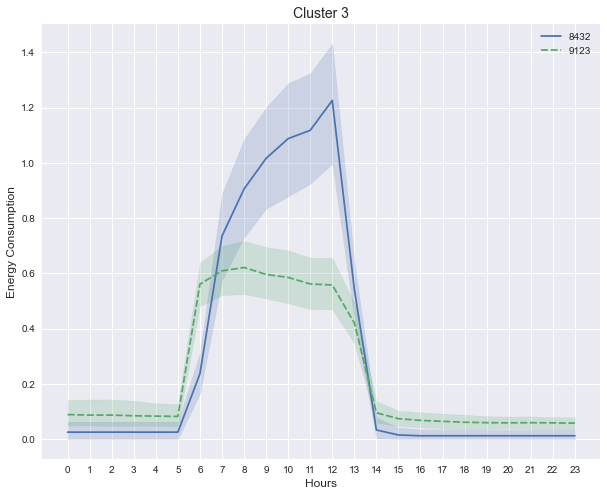

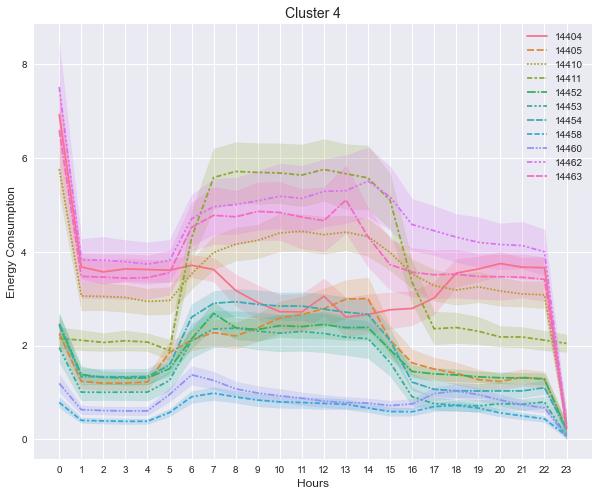

In [91]:
analysed_clusters = visualize_results(df,Hbscan_clusters,similar_to=None)
